## Combine Climatological Monthly SeaWIFS data into annual file and fill missing values

Author: Frank Bryan (bryan@ucar.edu ) 

In [1]:
%load_ext autoreload
%autoreload 2
import time
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean
import pandas as pd
%set_env CESMDATAROOT=/glade/scratch/bryan/tmp
from pop_tools import fill

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

env: CESMDATAROOT=/glade/scratch/bryan/tmp


In [2]:
import dask
dask.config.set({'distributed.dashboard.link': '/proxy/{port}/status'})

In [3]:
from ncar_jobqueue import NCARCluster
from dask.distributed import Client
cluster = NCARCluster(project='UCUB0094')

cluster.scale(2)
client = Client(cluster)
client
#print(cluster.dashboard_link)

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gseijo/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gseijo/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.6:34079,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gseijo/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
# File locations
path_in = '../ncfiles/'

file_ext_in = '.L3m_MC_CHL_chlor_a_9km.nc' # SeaWIFS 9km product
file_ext_out = '.L3m_MC_CHL_chlor_a_0.25deg.nc'
var_name = 'chlor_a'

file_mask = 'LandWater_SeaWIFS.nc'
ds_mask = xr.open_dataset(path_in+file_mask)

path_out = path_in
file_out = 'SeaWIFS' + file_ext_out

In [5]:
# Parameters for median filter
filt_size = 3

# Parameters for fill procedure
eps_std = 1.0e-5
nmax_std = 1000
omega_best=1.96

In [6]:
# Dates for month boundaries
dbeg = np.array([1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335])
#dbeg = np.array([1, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335])

dend = np.zeros_like(dbeg)
dend[:-1] = dbeg[1:]-1
dend[-1] = 365
dmid = 0.5*(dbeg + dend)

sybeg = ['1998','1998','1998','1998','1998','1998','1998','1998','1997','1997','1997','1997']
#sybeg = ['1998','1998','1998','1998','1998','1998','1998','1997','1997','1997','1997']
syend= 12*['2010']
#syend= 11*['2010']

def gen_datestr(ybeg,dbeg,yend,dend) :
    datestr = '{:s}{:03d}{:s}{:03d}'.format(ybeg,dbeg,yend,dend)
    return datestr

In [7]:
# Get the first file to grab the dimensions, coordinates
file_in = 'S' + gen_datestr(sybeg[0],dbeg[0],syend[0],dend[0]) + file_ext_in
print('Input file: ',file_in)
ds0 = xr.open_dataset(path_in+file_in)

latv= ds0['lat'].values
lonv = ds0['lon'].values

nlat=ds0.dims['lat']
lat = ds0['lat']

nlon=ds0.dims['lon']
lon = ds0['lon']
ntime=12
#ntime=11
time = xr.DataArray(dmid,dims=("time",),
                    attrs={"long_name":'Mid-Month Day of Climatological Year',
                           "units":'days'})

Input file:  S19980012010031.L3m_MC_CHL_chlor_a_9km.nc


In [8]:
# Set up masking arrays
OceanArea = ds_mask['Ocean'].astype('bool').compute() # area we want to fill
LandArea = ds_mask['Land'].astype('bool').compute() # area with values we don't want used
Everywhere = xr.ones_like(LandArea).astype('bool')

In [9]:
# Sample the data to get reduced grid lat/lon and masks
chl_c = ds0[var_name].coarsen(lon=filt_size,lat=filt_size,coord_func='median',keep_attrs=True).median().compute()

lon_c = chl_c.lon
nlon_c = lon_c.size
lat_c = chl_c.lat
nlat_c = lat_c.size

land_c = LandArea.sel(lon=lon_c,lat=lat_c,method='nearest').compute()
ocn_c = OceanArea.sel(lon=lon_c,lat=lat_c,method='nearest').compute()
all_c = xr.ones_like(chl_c).astype('bool')  # everywhere on the coarse grid    # Set a bogus value for the north pole

In [10]:
# Create a DataArray array to hold the input data
Chl_c = xr.DataArray(np.zeros((ntime,nlat_c,nlon_c)),
                        dims=("time","lat","lon"),
                        coords={"time":time,"lat":lat_c,"lon":lon_c}
                       )
Chl_cf = xr.ones_like(Chl_c)
Chl_cfm = xr.ones_like(Chl_c)

In [11]:
%%time
# Read the SeaWIFS data, coarsen, fill NaNs and store in DataArray
for n,d in enumerate(dbeg):
    file_in = 'S' + gen_datestr(sybeg[n],dbeg[n],syend[n],dend[n]) + file_ext_in
    print(n,file_in)
    
    ds_bfr = xr.open_dataset(path_in+file_in)
    #updated on 04/6/22: some files had different dimension indexing which brought index errors
    ds = xr.Dataset({'chlor_a': xr.DataArray(data   = ds_bfr[var_name].values,dims   = ['lat','lon'], coords = {'lat': latv,'lon': lonv})})
        
    # Mask out values in lakes and inland waters
    Chl_src = xr.where(LandArea,np.nan,ds[var_name])

    # Coarsen with a median filter
    print(' ... coarsening')
    c = Chl_src.coarsen(lon=filt_size,lat=filt_size,coord_func='median',keep_attrs=True).median().compute()

    # Fill NaNs in ocean areas
    print(' ... filling')
    cf = fill.lateral_fill(c.compute(),all_c,
            tol=eps_std,rc=omega_best,max_iter=nmax_std,use_sor=True)

    print(' ... masking')
    cfm = xr.where(land_c,np.nan,cf)

    # Put result in 3D array
    Chl_c.loc[dict(time=time[n])] = c
    Chl_cf.loc[dict(time=time[n])] = cf
    Chl_cfm.loc[dict(time=time[n])] = cfm
    
Chl_c.attrs = ds0[var_name].attrs
Chl_cf.attrs = ds0[var_name].attrs
Chl_cfm.attrs = ds0[var_name].attrs

0 S19980012010031.L3m_MC_CHL_chlor_a_9km.nc
 ... coarsening
 ... filling
 ... masking
1 S19980322010059.L3m_MC_CHL_chlor_a_9km.nc
 ... coarsening
 ... filling
 ... masking
2 S19980602010090.L3m_MC_CHL_chlor_a_9km.nc
 ... coarsening
 ... filling
 ... masking
3 S19980912010120.L3m_MC_CHL_chlor_a_9km.nc
 ... coarsening
 ... filling
 ... masking
4 S19981212010151.L3m_MC_CHL_chlor_a_9km.nc
 ... coarsening
 ... filling
 ... masking
5 S19981522010181.L3m_MC_CHL_chlor_a_9km.nc
 ... coarsening
 ... filling
 ... masking
6 S19981822010212.L3m_MC_CHL_chlor_a_9km.nc
 ... coarsening
 ... filling
 ... masking
7 S19982132010243.L3m_MC_CHL_chlor_a_9km.nc
 ... coarsening
 ... filling
 ... masking
8 S19972442010273.L3m_MC_CHL_chlor_a_9km.nc
 ... coarsening
 ... filling
 ... masking
9 S19972742010304.L3m_MC_CHL_chlor_a_9km.nc
 ... coarsening
 ... filling
 ... masking
10 S19973052010334.L3m_MC_CHL_chlor_a_9km.nc
 ... coarsening
 ... filling
 ... masking
11 S19973352010365.L3m_MC_CHL_chlor_a_9km.nc
 ... coa

In [12]:
cfm = xr.where(land_c,np.nan,cf)

    # Put result in 3D array
Chl_c.loc[dict(time=time[n])] = c
Chl_cf.loc[dict(time=time[n])] = cf
Chl_cfm.loc[dict(time=time[n])] = cfm

In [13]:
ds_out = xr.Dataset({var_name:Chl_c,
                     var_name+'_cf':Chl_cf,
                     var_name+'_cfm':Chl_cfm,
                     'ocean_mask':ocn_c,
                     'land_mask':land_c})
ds_out.to_netcdf(path_out+file_out)

Text(0, 0.5, 'mg / m$^3$')

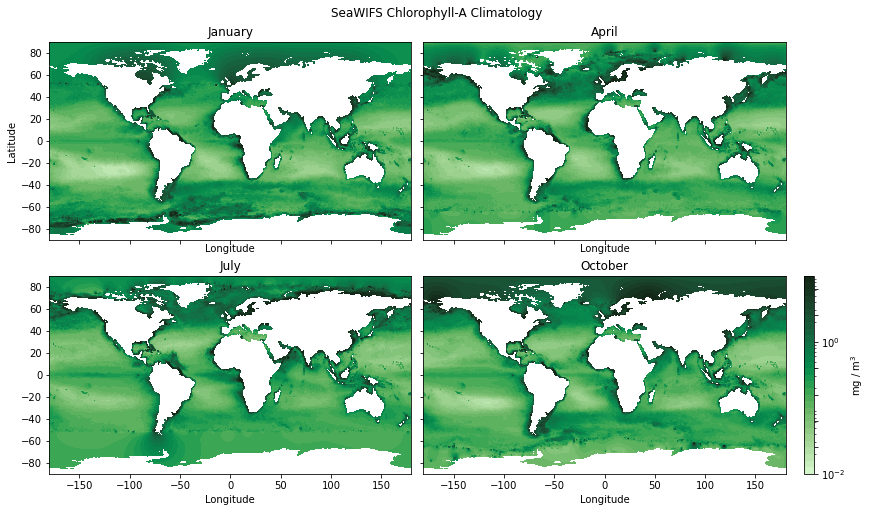

In [14]:
clev_exp = np.linspace(-2,1,num=31)
clev_exp = np.power(10, clev_exp)

cm = cmocean.cm.algae

fig,ax=plt.subplots(nrows=2,ncols=2,sharex=True,sharey=True,
                    figsize=(12,7),constrained_layout=True)
[axul,axur,axll,axlr] = ax.flatten()
fig.suptitle('SeaWIFS Chlorophyll-A Climatology')

cf0=axul.contourf(lon_c,lat_c,Chl_cfm.isel(time=0),
                levels=clev_exp,norm=colors.LogNorm(),cmap=cm)
axul.set_title('January')
axul.set_xlabel('Longitude')
axul.set_ylabel('Latitude')

cf1=axur.contourf(lon_c,lat_c,Chl_cfm.isel(time=3),
                   levels=clev_exp,norm=colors.LogNorm(),cmap=cm)
axur.set_title('April')
axur.set_xlabel('Longitude')

cf2=axll.contourf(lon_c,lat_c,Chl_cfm.isel(time=6),
                   levels=clev_exp,norm=colors.LogNorm(),cmap=cm)
axll.set_title('July')
axul.set_ylabel('Latitude')
axll.set_xlabel('Longitude')

cf3=axlr.contourf(lon_c,lat_c,Chl_cfm.isel(time=9),
                   levels=clev_exp,norm=colors.LogNorm(),cmap=cm)
axlr.set_title('October')
axlr.set_xlabel('Longitude')


cbar = fig.colorbar(cf0)
cbar.ax.set_ylabel('mg / m$^3$')